In [1]:
# My libraries that I use

import numpy as np
import json
import matplotlib.pyplot as plt
from pylab import cm
from sklearn.decomposition import NMF
from scipy import ndimage,interpolate
from matplotlib.patches import Rectangle
from matplotlib import patheffects as pe
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

In [2]:
# My functions for loading HAADF data, need the .npy and .json exported directly from Swift (select Raw NumPy option)

def LoadImage(fname):
    """
    Loads a 2D STEM Image
    
    Input:  fname - path to either .npy or .json file that (string)
    Output: im    - image data (numpy array)
            cal   - pixel calibration in nm (float)
            mdat  - metadata (python dictionary)
    """    

    if fname.endswith('npy'): fname=fname[:-4]
    if fname.endswith('json'): fname=fname[:-5]
    dat=np.load(fname+'.npy')
    mdat= json.load(open(fname+'.json','r'))
    cal=mdat['spatial_calibrations'][0]['scale']
    return dat,cal,mdat

# Function to add a clean scale bar to images

def AddScaleBar(axis,scale,cal,w=None,xy=None,units='nm',fontsize=10,text=True):
    """
    Adds scale bar to an image in a subplot
    Input:    axis     - subplot axis for added scalebar (matplotlib axis)
              scale    - desired length of scalebar in desired unit (int)
              cal      - calibration of image in desired units/pixel (float)
    Optional: w        - width of scale bar in pixels (float) Default: 1/50th of image height
              xy       - coordinates of top left corner of scale bar (tuple) NOTE: coordinates of bar not text
                          Default: None (puts bar w pixels in each dimension away from bottom left corner)
              units    - desired units (str) Default: 'nm'
              fontsize - size of font (float) Default: 8
              text     - Display actual text of scale bar (bool) Default: True
    Output: fig - displayed image (matplotlib figure)
    """   
    imdim=axis.get_images()[0].get_extent()
    dim=[int(imdim[2]-imdim[3]),int(imdim[1]-imdim[-0])]
    if not w: w=dim[0]/50.
    if not xy: xy=(w,dim[0]-2*w)
    axis.add_patch(Rectangle(xy,scale/cal,w,fc='w',ec='k',lw=0.5))
    if text: 
        txt=axis.text(xy[0]+0.5*scale/cal,xy[1],str(scale)+' '+units,fontweight='bold',color='w',fontsize=fontsize,ha='center',va='bottom')
        txt.set_path_effects([pe.withStroke(linewidth=1,foreground='k')])
    return

All Metadata
{'version': 1, 'reader_version': 1, 'spatial_calibrations': [{'offset': -37.59765625, 'scale': 1.3671875, 'units': 'nm'}, {'offset': -37.59765625, 'scale': 1.3671875, 'units': 'nm'}], 'intensity_calibration': {'offset': 0.0, 'scale': 1.0, 'units': ''}, 'collection_dimension_count': 0, 'datum_dimension_count': 2, 'metadata': {'hardware_source': {'autostem': {'high_tension_v': 60000.0, 'defocus_m': -1.5714191727764214e-07, 'ImageScanned:C1 ConstW': 0.342, 'ImageScanned:C10': -1.57142e-07, 'ImageScanned:C12.a': 2.02169e-08, 'ImageScanned:C12.b': 4.3929e-09, 'ImageScanned:C21.a': 0.0, 'ImageScanned:C21.b': 0.0, 'ImageScanned:C23.a': 0.0, 'ImageScanned:C23.b': 0.0, 'ImageScanned:C30': 2.93486e-05, 'ImageScanned:C32.a': 7.17875e-06, 'ImageScanned:C32.b': -9.63465e-06, 'ImageScanned:C34.a': 2.5684e-06, 'ImageScanned:C34.b': -1.86531e-05, 'ImageScanned:C41.a': 0.0, 'ImageScanned:C41.b': 0.0, 'ImageScanned:C43.a': 0.0, 'ImageScanned:C43.b': 0.0, 'ImageScanned:C45.a': 0.0, 'ImageSca

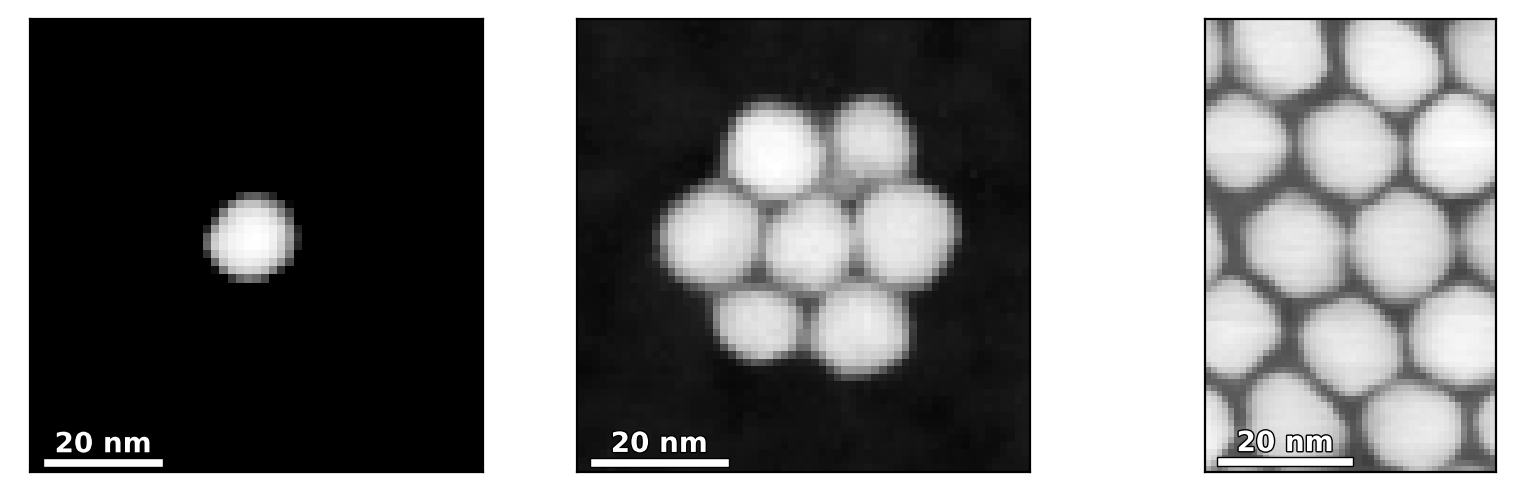

In [3]:
#Load HAADF data

fname='/Users/j6h/Analyses/Data/Me/CuratedNotebookData/Isolated_Z.npy'
Z_Single,Z_Single_cal,Z_Single_mdat=LoadImage(fname)

fname='/Users/j6h/Analyses/Data/Me/CuratedNotebookData/HoneyComb_Z.npy'
Z_Cluster,Z_Cluster_cal,Z_Cluster_mdat=LoadImage(fname)

fname='/Users/j6h/Analyses/Data/Me/CuratedNotebookData/MediumArea_Z.npy'
Z_Array,Z_Array_cal,Z_Array_mdat=LoadImage(fname)

print('All Metadata')
print(Z_Single_mdat)
print('Spatial Calibrations')
print(Z_Single_mdat['spatial_calibrations'])

f,a=plt.subplots(1,3,dpi=200,figsize=(10,3))
plt.setp(a,xticks=[],yticks=[])
a[0].imshow(Z_Single,cmap=cm.Greys_r,vmin=0)
AddScaleBar(a[0],20,Z_Single_cal)
a[1].imshow(Z_Cluster,cmap=cm.Greys_r,vmin=0)
AddScaleBar(a[1],20,Z_Cluster_cal)
a[2].imshow(Z_Array,cmap=cm.Greys_r,vmin=0)
AddScaleBar(a[2],20,Z_Array_cal)

In [4]:
# Functions to load and calibrate spectrum images

def LoadEELS_SI(fname):
    """
    Loads an EEL Spectrum Image
    
    Input:  fname - path to either .npy or .json file that (string)
    Output: dat   - data (numpy array)
            cal   - pixel calibration in nm (float)
            disp  - energy dispersion in eV (float)
            mdat  - metadata (python dictionary)
    """    

    if fname.endswith('npy'): fname=fname[:-4]
    if fname.endswith('json'): fname=fname[:-5]
    dat=np.load(fname+'.npy')
    mdat= json.load(open(fname+'.json','r'))
    cal=mdat['spatial_calibrations'][0]['scale']
    disp=mdat['spatial_calibrations'][-1]['scale']
    return dat,cal,disp,mdat

def GetSIEnergyAxes(dat,disp,style='fwhm',subpix_w=30):
    """
    Creates a numpy array of calibrated energy loss axes calibrated to individual spectra in SI
    
    Input:    dat      - data (numpy array)
              disp     - energy dispersion in eV (float)
              style    - 'pixel': calibrates to pixel with max intensity of ZLP
                         'fwhm': calibrates to center of fwhm of ZLP (Default)
                         'subpixel': fits gaussian to a number of pixels around the ZLP (w pixels)
    Optional: subpix_w - Number of pixels for sub-pixel ZLP fit (Default = 30)
    Output:   ens      - calibrated energy axes (numpy array)
    """   
    
    E_init=np.arange(0,dat.shape[-1])*disp
    w=int(subpix_w/2.)
    if style=='pixel':
        centers=np.array([[E_init[np.argmax(s)] for s in row] for row in dat])
    if style=='fwhm':
        centers=np.asarray([[np.average(Get_FWHM(E_init,s)[:2]) for s in row] for row in dat])
    if style=='subpixel':
        centers=np.array([[optimize.curve_fit(gauss,E_init[np.argmax(s)-w:np.argmax(s)+w],
                s[np.argmax(s)-w:np.argmax(s)+w]/np.amax(s))[0][1] for s in row] for row in dat])
    ens=np.array([[E_init-c for c in row] for row in centers])
    return ens

def GetCalibratedSI(dat,ens,en_lo=None,en_hi=None,n_int=None):
    """
    Creates new interpolated energy-loss axis to which all spectra in the SI are aligned
    
    Input:    dat   - data (numpy array)
              ens   - calibrated energy axes (numpy array)
    Optional: en_lo  - desired lowest energy of the output data (float)
                        Default: None (finds highest minimum energy available for all spectra)
              en_hi  - desired highest energy of cropped data (float)
                        Default: None (finds lowest maximum energy available for all spectra)
              n_int - Number of data points for interpolated axis (int)
                        Default: None (chooses number to be closest to as-acquired dispersion)
    Output:   E     - calibrated energy axis (numpy array)
              SI    - calibrated spectrum image (numpy array)
    """   
    
    m=np.amax(ens[:,:,0]);M=np.amin(ens[:,:,-1])  
    dispersion=ens[0,0,1]-ens[0,0,0]
    if not en_lo or en_lo<m: en_lo=m
    if not en_hi or en_hi>M: en_hi=M
    if not n_int: n_int=int((en_hi-en_lo)/dispersion)
    E=np.linspace(en_lo,en_hi,n_int)
    dim=ens.shape
    SI=np.zeros((*dim[:2],n_int))
    for i in range(dim[0]):
        for j in range(dim[1]):
            k1=Get_i(ens[i,j],en_lo);k2=Get_i(ens[i,j],en_hi)
            fSI=interpolate.interp1d(ens[i,j],dat[i,j],kind='linear')
            SI[i,j]=fSI(E)
    return E,SI

# Functions to facilitate easy analysis (also needed for SI calibration)

def NormArray(arr):
    """
    Converts an array of arbitrary values to a 0-1 range
    
    Input:  arr  - numpy array
    Output: narr - normalized numpy array
    """    
    
    arr = np.asarray(arr)
    M=np.amax(arr);m=np.amin(arr)
    narr = (arr-m)/(M-m)
    return narr

def Get_i(arr,val):
    """
    Gives index of array closest to desired value
    
    Input:  arr - numpy array
            val - float
    Output: i   - index of closest value to desired float (int)
    """    
    
    i=np.argmin(np.abs(arr-val))
    return i

def Get_FWHM(en,spec,interp=False):
    """
    Finds FWHM of ZLP and returns half-maxes and width in energy
    
    Input:  en    - energy loss axis (numpy array)
            spec  - EELS axis (numpy array)
    Output: en_lo - energy of lower half max in eV (float)
            en_hi - energy of upper half max in eV (float)
            en_w  - FWHM of ZLP in eV (float)
    """    
    
    s=NormArray(spec)
    i_lo=Get_i(s[:np.argmax(s)],0.5)
    i_hi=Get_i(s[np.argmax(s):],0.5)+np.argmax(s)
    if interp:
        #disp=en[1]-en[0];disp_i=disp/100.
        #en_lo_fit=np.arange(en[i_lo-1:i_lo+1],disp_i);en_hi_fit=np.arange(en[i_hi-1:i_hi+1],disp_i)
        f_lo=interpolate.interp1d(s[i_lo-1:i_lo+2],en[i_lo-1:i_lo+2])
        f_hi=interpolate.interp1d(s[i_hi-1:i_hi+2],en[i_hi-1:i_hi+2])
        print(i_lo,i_hi)
        en_lo=f_lo(0.5);en_hi=f_hi(0.5)
    else: en_lo=en[i_lo];en_hi=en[i_hi]
    en_w=en_hi-en_lo
    return en_lo,en_hi,en_w

In [5]:
fname='/Users/j6h/Analyses/Data/Me/CuratedNotebookData/Isolated_SI.npy'
SI_Single_dat,SI_Single_cal,SI_Single_disp,SI_Single_mdat=LoadEELS_SI(fname)

# Generate calibrated energy axes for each spectrum in spectrum image

SI_Single_ens=GetSIEnergyAxes(SI_Single_dat,SI_Single_disp)

# Generate calibrated spectrum image single calibrated energy axis

E_Single,SI_Single=GetCalibratedSI(SI_Single_dat,SI_Single_ens)

fname='/Users/j6h/Analyses/Data/Me/CuratedNotebookData/HoneyComb_SI.npy'
SI_Cluster_dat,SI_Cluster_cal,SI_Cluster_disp,SI_Cluster_mdat=LoadEELS_SI(fname)
SI_Cluster_ens=GetSIEnergyAxes(SI_Cluster_dat,SI_Cluster_disp)
E_Cluster,SI_Cluster=GetCalibratedSI(SI_Cluster_dat,SI_Cluster_ens)

fname='/Users/j6h/Analyses/Data/Me/CuratedNotebookData/MediumArea_SI.npy'
SI_Array_dat,SI_Array_cal,SI_Array_disp,SI_Array_mdat=LoadEELS_SI(fname)
SI_Array_ens=GetSIEnergyAxes(SI_Array_dat,SI_Array_disp)
E_Array,SI_Array=GetCalibratedSI(SI_Array_dat,SI_Array_ens)

Calibration is necessary to correct ZLP centering, always worth checking it.

Text(0.5, 1.0, 'ZLP (Calibrated)')

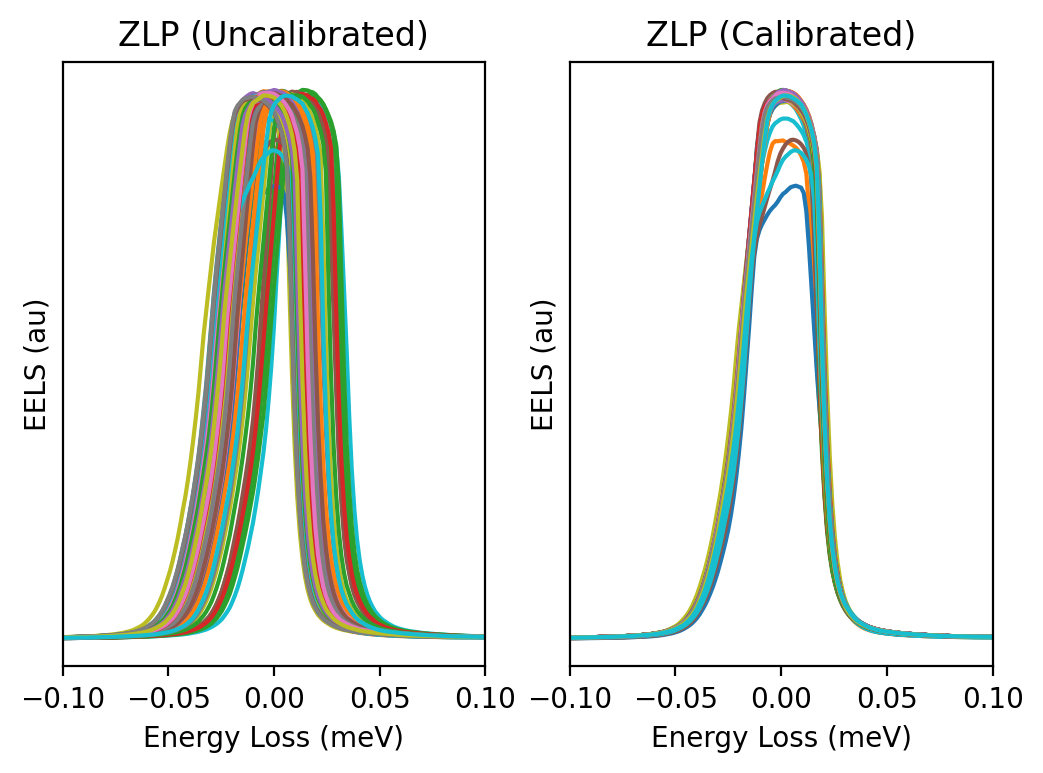

In [6]:
#Check to see if calibration worked sensibly. Single particle dataset first

#Generate energy axis for uncalibrated dataset
E_Single_AvMax=np.argmax(np.average(SI_Single_dat,axis=(0,1)))
E_Single_N_Spec=SI_Single_dat.shape[2]
E_Single_uncalibrated=(np.arange(E_Single_N_Spec)-E_Single_AvMax)*SI_Single_disp

#Grab 100 random spectra from the spectrum image
f,a=plt.subplots(1,2,dpi=200)
plt.setp(a,yticks=[],ylabel='EELS (au)',xlabel='Energy Loss (meV)',xlim=(-0.1,0.1))
for N in range(200):
    i=np.random.randint(SI_Single.shape[0])
    j=np.random.randint(SI_Single.shape[1])
    a[0].plot(E_Single_uncalibrated,SI_Single_dat[i,j])
    a[1].plot(E_Single,SI_Single[i,j])

a[0].set_title('ZLP (Uncalibrated)')
a[1].set_title('ZLP (Calibrated)')

Text(0.5, 1.0, 'ZLP (Calibrated)')

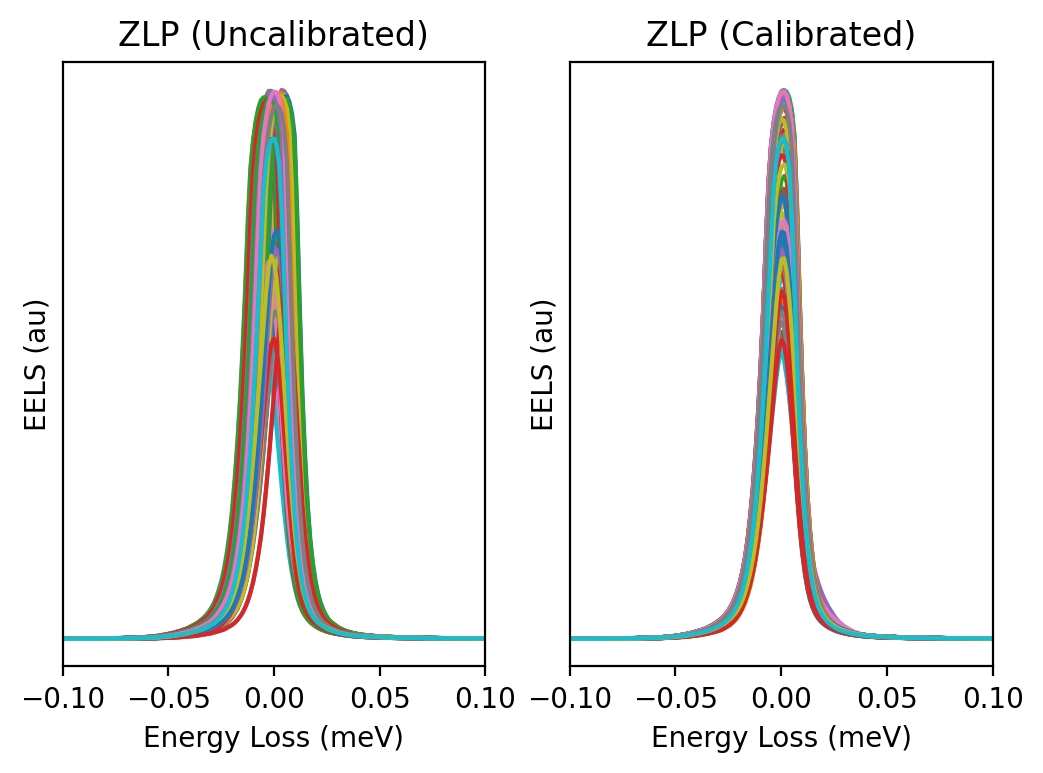

In [7]:
#Check to see if calibration worked sensibly. Cluster particle dataset next

#Generate energy axis for uncalibrated dataset
E_Cluster_AvMax=np.argmax(np.average(SI_Cluster_dat,axis=(0,1)))
E_Cluster_N_Spec=SI_Cluster_dat.shape[2]
E_Cluster_uncalibrated=(np.arange(E_Cluster_N_Spec)-E_Cluster_AvMax)*SI_Cluster_disp

#Grab 100 random spectra from the spectrum image
f,a=plt.subplots(1,2,dpi=200)
plt.setp(a,yticks=[],ylabel='EELS (au)',xlabel='Energy Loss (meV)',xlim=(-0.1,0.1))
for N in range(200):
    i=np.random.randint(SI_Cluster.shape[0])
    j=np.random.randint(SI_Cluster.shape[1])
    a[0].plot(E_Cluster_uncalibrated,SI_Cluster_dat[i,j])
    a[1].plot(E_Cluster,SI_Cluster[i,j])

a[0].set_title('ZLP (Uncalibrated)')
a[1].set_title('ZLP (Calibrated)')

Text(0.5, 1.0, 'ZLP (Calibrated)')

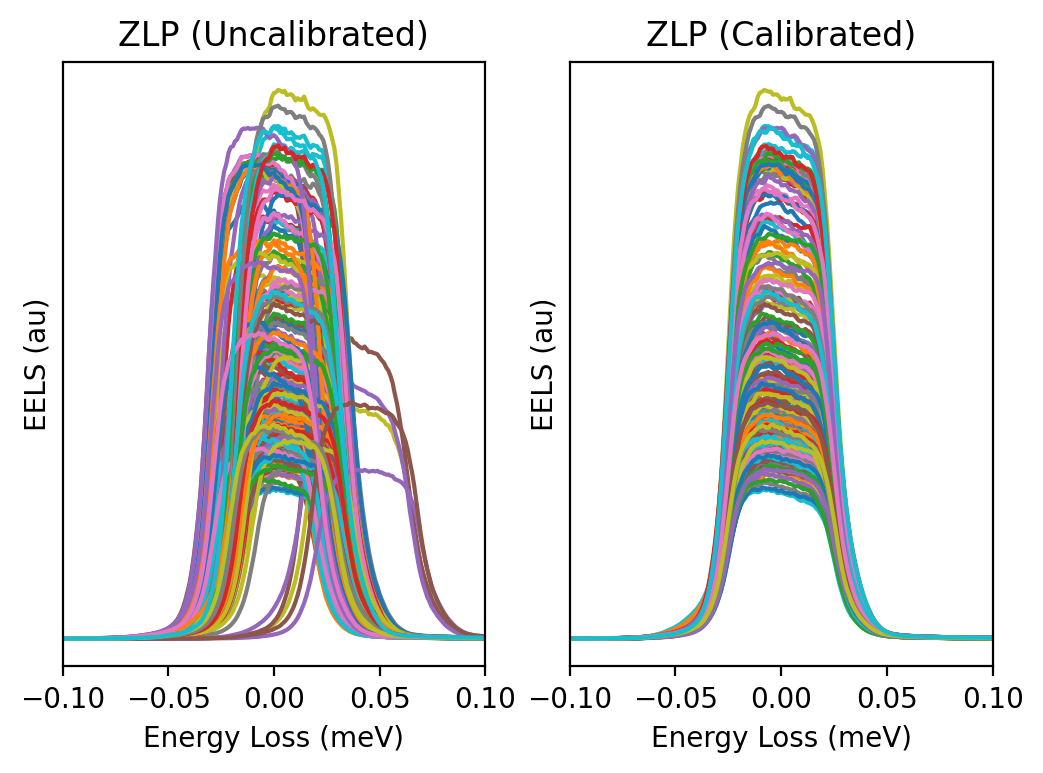

In [8]:
#Check to see if calibration worked sensibly. Array particle dataset last

#Generate energy axis for uncalibrated dataset
E_Array_AvMax=np.argmax(np.average(SI_Array_dat,axis=(0,1)))
E_Array_N_Spec=SI_Array_dat.shape[2]
E_Array_uncalibrated=(np.arange(E_Array_N_Spec)-E_Array_AvMax)*SI_Array_disp

#Grab 100 random spectra from the spectrum image
f,a=plt.subplots(1,2,dpi=200)
plt.setp(a,yticks=[],ylabel='EELS (au)',xlabel='Energy Loss (meV)',xlim=(-0.1,0.1))
for N in range(200):
    i=np.random.randint(SI_Array.shape[0])
    j=np.random.randint(SI_Array.shape[1])
    a[0].plot(E_Array_uncalibrated,SI_Array_dat[i,j])
    a[1].plot(E_Array,SI_Array[i,j])

a[0].set_title('ZLP (Uncalibrated)')
a[1].set_title('ZLP (Calibrated)')

In [9]:
# Function to help visualize spectrum image

def SI_Analyzer(E,SI,En,En_W,Regions,R_W,visualize=True,Colors=None,cmap=None,xlim=None,ylim=None,yscale='linear'):
    """
    Takes a spectrum image and outputs an SI slice and a series of representative spectra from selectable energy ranges and locations
    
    Input:    E        - energy axis of EEL spectrum (numpy array)
              SI       - 3D EEL spectrum image (numpy array)
              En       - energy center of the SI slice (float)
              En_W     - energy width of the SI slice (float)
              Regions  - list of y,x coordinates (in pixels) for upper left corner for representative spectra location (list of integer tuples)
              R_W      - number of integrated pixels in each dimension for representative spectra (int)
    Optional: viualize - Plot output (boolean): Default - True
              Colors   - customized list of colors for representative spectra (list of fractional RGB values, i.e. [(1.0, 0., 0.)])
              cmap     - custom color map for SI Slice: Default - cm.inferno
              xlim     - customized x limits of representative spectra plot
              ylim     - customized y limits of representative spectra plot 
              yscale   - y scale of representative spectra plot: Default - 'linear' (can be 'log')
    Output:   E_out    - energy axis of the fitted region (numpy array)
              BG_out   - background intensity in fitted region (numpy array)
              S_out    - EELS intensity in fitted region (numpy array)    
    """       
    Specs=[np.average(SI[R[0]:R[0]+R_W,R[1]:R[1]+R_W],axis=(0,1)) for R in Regions]
    Slice=np.average(SI[:,:,Get_i(E,En-En_W/2.):Get_i(E,En+En_W/2.)],axis=2)
    if visualize:
        if not Colors: Colors=[plt.get_cmap("tab10")(i) for i in range(len(Regions))]
        if not cmap: cmap=cm.inferno
        f,a=plt.subplots(1,2,figsize=(9,3),dpi=200)
        cb=a[0].imshow(Slice,cmap=cmap)
        for R,S,C in zip(Regions,Specs,Colors):
            a[0].add_patch(Rectangle((R[1]-0.5,R[0]-0.5),R_W,R_W,fc='none',ec='k',lw=2.5))
            a[0].add_patch(Rectangle((R[1]-0.5,R[0]-0.5),R_W,R_W,fc='none',ec=C,lw=1.25))
            a[1].plot(E,S,color=C,lw=0.5)

        plt.setp(a[0],xticks=[],yticks=[])
        xy=a[0].get_position()
        cbax=f.add_axes([xy.x0,xy.y0-0.05,xy.width,0.03])
        plt.colorbar(cb,cax=cbax,orientation='horizontal')
        cbax.set_xlabel('Slice Intensity (Counts)')

        plt.setp(a[1],xlabel='Energy Loss (eV)',ylabel='Intensity (counts)')
        ym,yM=a[1].get_ylim()
        a[1].fill_betweenx([ym,yM],E[Get_i(E,En-En_W/2.)],E[Get_i(E,En+En_W/2.)],color=cmap(0.5),alpha=0.3,lw=0)
        if xlim: a[1].set_xlim(xlim[0],xlim[1])
        if ylim: a[1].set_ylim(ylim[0],ylim[1])
        else: a[1].set_ylim(ym,yM)
        a[1].set_yscale(yscale)
        
    return Specs,Slice


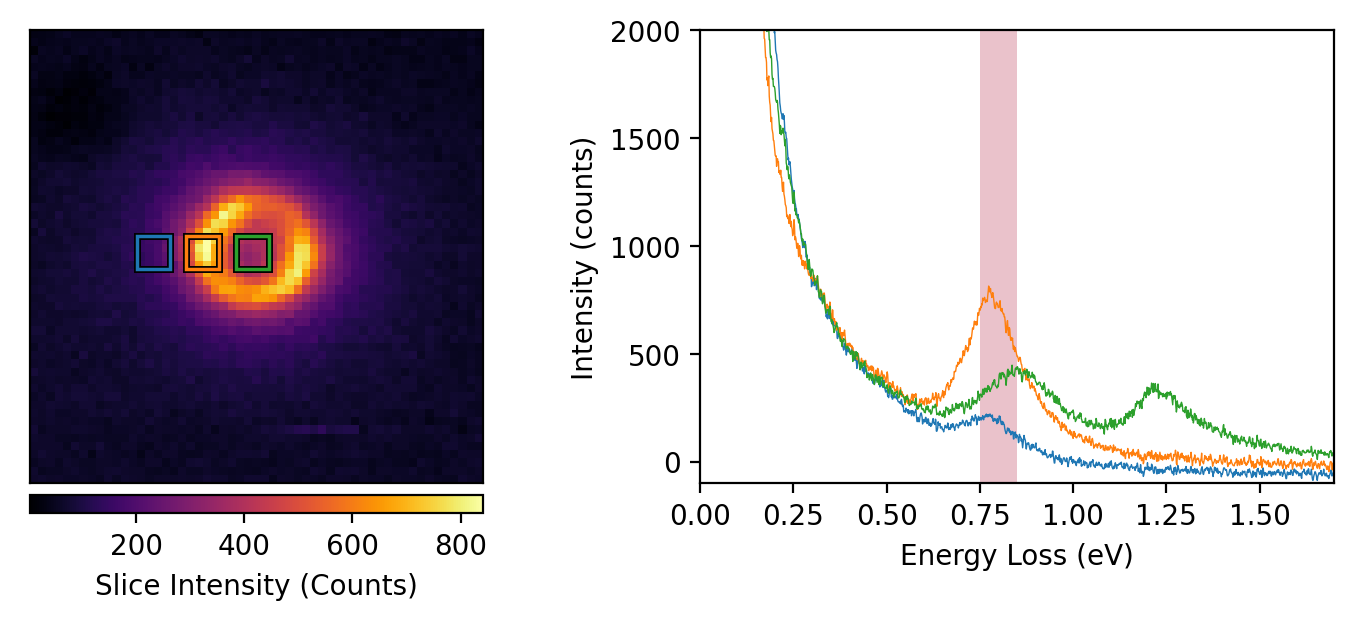

In [10]:
Rs_Single=[[25,13],[25,19],[25,25]]
SI_Single_Specs,SI_Single_Slice=SI_Analyzer(E_Single,SI_Single,0.8,0.1,Rs_Single,4,xlim=(0,1.7),ylim=(-100,2000))

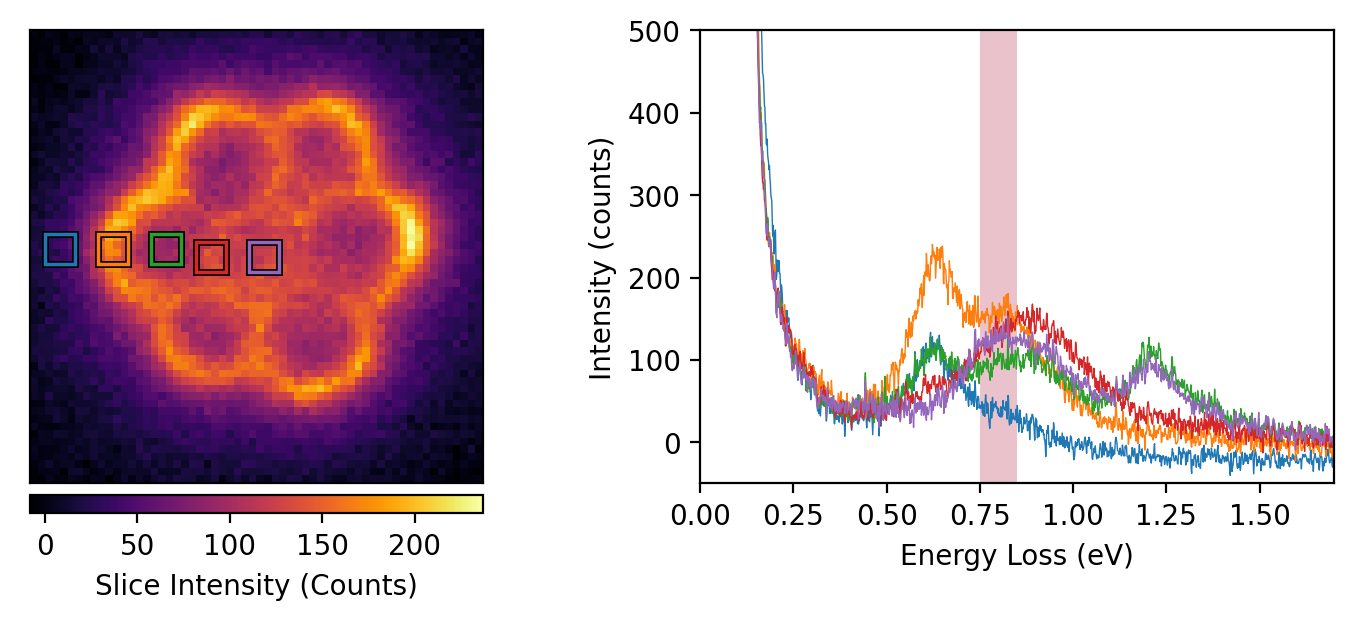

In [11]:
Rs_Cluster=[[27,2],[27,9],[27,16],[28,22],[28,29]]
SI_Cluster_Specs,SI_Cluster_Slice=SI_Analyzer(E_Cluster,SI_Cluster,0.8,0.1,Rs_Cluster,4,xlim=(0,1.7),ylim=(-50,500))

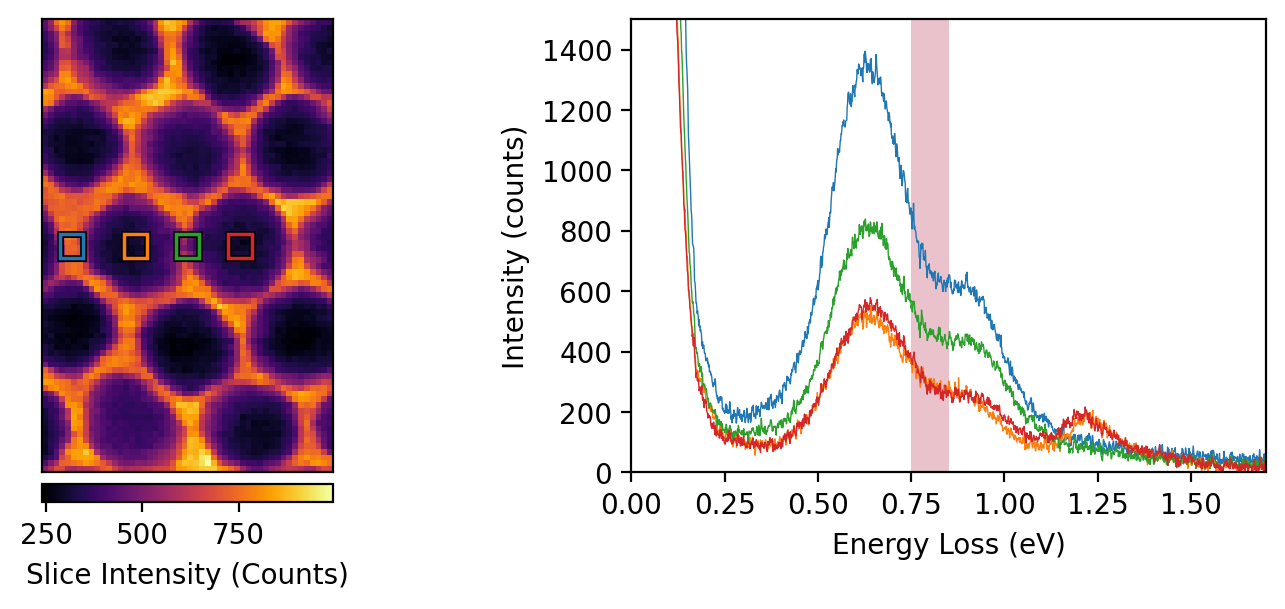

In [12]:
Rs_Array=[[37,3],[37,14],[37,23],[37,32]]
SI_Array_Specs,SI_Array_Slice=SI_Analyzer(E_Array,SI_Array,0.8,0.1,Rs_Array,4,xlim=(0,1.7),ylim=(0,1500))

In [13]:
def FitPowerlaw(E,S,fen_lo,fen_hi,visualize=True):
    """
    Fits a power law background to an EEL spectrum over an energy ranges
    
    Input:    E        - energy axis of EEL spectrum (numpy array)
              S        - EELS axis of EEL spectrum (numpy array)
              fen_lo   - lower energy limit (float)
              fen_hi   - upper energy limit (float)
    Optional: viualize - Plot output (boolean): Default - True
    Output:   E_out    - energy axis of the fitted region (numpy array)
              BG_out   - background intensity in fitted region (numpy array)
              S_out    - EELS intensity in fitted region (numpy array)    
    """   
    i_lo=Get_i(E,fen_lo);i_hi=Get_i(E,fen_hi)
    elog=np.log(E[i_lo:i_hi][np.where(S[i_lo:i_hi]>0)])
    slog=np.log(S[i_lo:i_hi][np.where(S[i_lo:i_hi]>0)])
    r,A0=np.polyfit(elog,slog,1)
    E_out=E[i_lo:]
    BG_out=np.exp(A0)*E[i_lo:]**(r)
    S_out=S[i_lo:]-BG_out
    if visualize:
        f,a=plt.subplots(3,1,figsize=(4,10),dpi=100)
        a[0].plot(E,NormArray(S),color='k',label='Data')
        a[0].plot(E[i_lo:i_hi],NormArray(S)[i_lo:i_hi],marker='o',ms=7,markerfacecolor='none',markeredgecolor='r',lw=0,alpha=0.5,markevery=5,label='Fit Region')
        a[0].legend(frameon=False,fontsize=10)
        a[0].set_yscale('log')
        a[0].set_xlabel('Energy Loss (eV)')
        a[0].set_ylabel('Normalized Intensity (au)')
        a[1].plot(E,NormArray(S),color='k',label='Data')
        BG_norm=(BG_out-np.amin(S))/np.ptp(S)
        a[1].plot(E_out,BG_norm,color='b',lw=3,label='Power Law Fit')
        a[1].legend(frameon=False,fontsize=10)
        a[1].set_yscale('log')   
        a[1].set_xlabel('Energy Loss (eV)')
        a[1].set_ylabel('Normalized Intensity (au)')
        a[2].plot(E_out,S_out,color='b',label='Bkg. Subtracted Data')
        a[2].axhline(0,color='k',lw=0.5,ls='--')
        a[2].set_xlabel('Energy Loss (eV)')
        a[2].set_ylabel('Intensity (counts)')      
    return E_out,BG_out,S_out

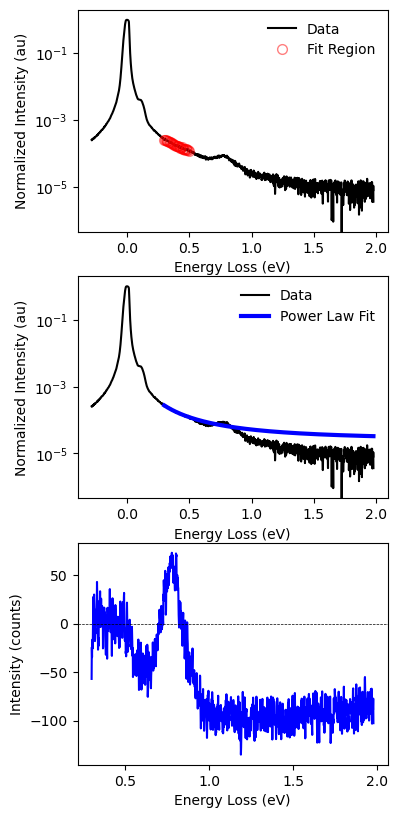

In [14]:
E_Single_f,BG_Single_f,SI_Single_Specs0_f=FitPowerlaw(E_Single,SI_Single_Specs[0],0.3,0.5)

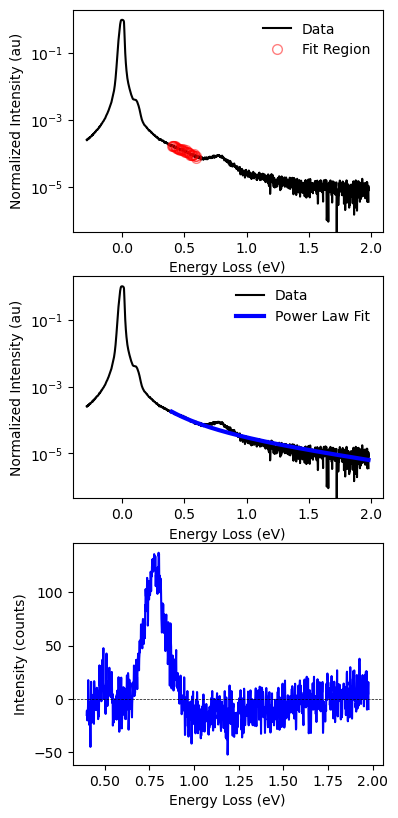

In [15]:
offset=100
E_Single_f,BG_Single_f,SI_Single_Specs0_f=FitPowerlaw(E_Single,SI_Single_Specs[0]+offset,0.4,0.6)

In [16]:
def FitPowerlaw2R(E,S,fen_lo_1,fen_hi_1,fen_lo_2,fen_hi_2,visualize=True):
    """
    Fits a power law background to an EEL spectrum over two energy ranges
    
    Input:    E        - energy axis of EEL spectrum (numpy array)
              S        - EELS axis of EEL spectrum (numpy array)
              fen_lo_1 - lower energy range lower limit (float)
              fen_hi_1 - lower energy range upper limit (float)
              fen_lo_2 - upper energy range lower limit (float)
              fen_hi_2 - upper energy range upper limit (float)
    Optional: viualize - Plot output (boolean): Default - True
    Output:   E_out    - energy axis of the fitted region (numpy array)
              BG_out   - background intensity in fitted region (numpy array)
              S_out    - EELS intensity in fitted region (numpy array)    
    """   
    
    i_lo_1=Get_i(E,fen_lo_1);i_hi_1=Get_i(E,fen_hi_1)
    i_lo_2=Get_i(E,fen_lo_2);i_hi_2=Get_i(E,fen_hi_2)
    E_Fit,S_Fit=np.append(E[i_lo_1:i_hi_1],E[i_lo_2:i_hi_2]), np.append(S[i_lo_1:i_hi_1],S[i_lo_2:i_hi_2])
    elog=np.log(E_Fit[np.where(S_Fit>0)])
    slog=np.log(S_Fit[np.where(S_Fit>0)])
    r,A0=np.polyfit(elog,slog,1)
    E_out=E[i_lo_1:]
    BG_out=np.exp(A0)*E[i_lo_1:]**(r)
    S_out=S[i_lo_1:]-BG_out
    if visualize:
        f,a=plt.subplots(3,1,figsize=(4,10),dpi=100)
        a[0].plot(E,NormArray(S),color='k',label='Data')
        a[0].plot(E[i_lo_1:i_hi_1],NormArray(S)[i_lo_1:i_hi_1],marker='o',ms=7,
                  markerfacecolor='none',markeredgecolor='r',lw=0,alpha=0.5,markevery=5)
        a[0].plot(E[i_lo_2:i_hi_2],NormArray(S)[i_lo_2:i_hi_2],marker='o',ms=7,
                  markerfacecolor='none',markeredgecolor='r',lw=0,alpha=0.5,markevery=5,
                  label='Fit Region')
        a[0].legend(frameon=False,fontsize=10)
        a[0].set_yscale('log')
        a[0].set_xlabel('Energy Loss (eV)')
        a[0].set_ylabel('Normalized Intensity (au)')
        a[1].plot(E,NormArray(S),color='k',label='Data')
        BG_norm=(BG_out-np.amin(S))/np.ptp(S)
        a[1].plot(E_out,BG_norm,color='b',lw=3,label='Power Law Fit')
        a[1].legend(frameon=False,fontsize=10)
        a[1].set_yscale('log')   
        a[1].set_xlabel('Energy Loss (eV)')
        a[1].set_ylabel('Normalized Intensity (au)')
        a[2].plot(E_out,S_out,color='b',label='Bkg. Subtracted Data')
        a[2].axhline(0,color='k',lw=0.5,ls='--')
        a[2].set_xlabel('Energy Loss (eV)')
        a[2].set_ylabel('Intensity (counts)')      
    return E_out,BG_out,S_out

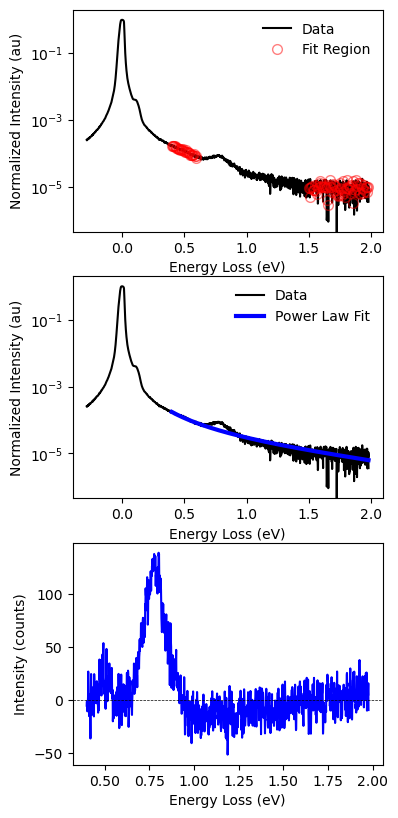

In [17]:
offset=100
E_Single_f,BG_Single_f,SI_Single_Specs0_f=FitPowerlaw2R(E_Single,SI_Single_Specs[0]+offset,0.4,0.6,1.5,2.0)

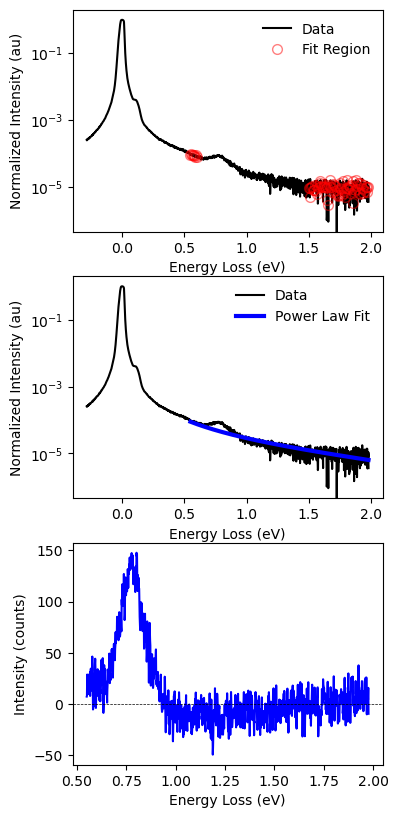

In [18]:
offset=100
E_Single_f,BG_Single_f,SI_Single_Specs0_f=FitPowerlaw2R(E_Single,SI_Single_Specs[0]+offset,0.55,0.6,1.5,2.0)

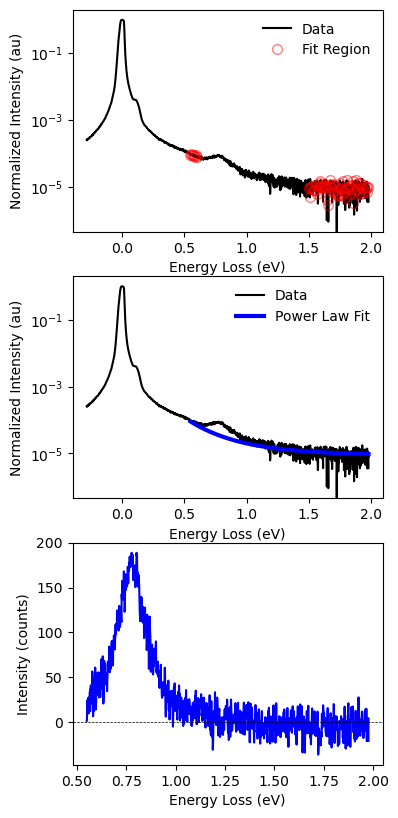

In [19]:
offset=60
E_Single_f,BG_Single_f,SI_Single_Specs0_f=FitPowerlaw2R(E_Single,SI_Single_Specs[0]+offset,0.55,0.6,1.5,2.0)

In [20]:
def FitExponential2R(E,S,N,fen_lo_1,fen_hi_1,fen_lo_2,fen_hi_2,visualize=True):
    """
    Fits an exponential to an EEL spectrum over two energy ranges
    
    Input:    E        - energy axis of EEL spectrum (numpy array)
              S        - EELS axis of EEL spectrum (numpy array)
              N        - order of exponential polynomial used for fit (int)
              fen_lo_1 - lower energy range lower limit (float)
              fen_hi_1 - lower energy range upper limit (float)
              fen_lo_2 - upper energy range lower limit (float)
              fen_hi_2 - upper energy range upper limit (float)
    Optional: viualize - Plot output (boolean): Default - True
    Output:   E_out    - energy axis of the fitted region (numpy array)
              BG_out   - background intensity in fitted region (numpy array)
              S_out    - EELS intensity in fitted region (numpy array)    
    """   
    
    i_lo_1=Get_i(E,fen_lo_1);i_hi_1=Get_i(E,fen_hi_1)
    i_lo_2=Get_i(E,fen_lo_2);i_hi_2=Get_i(E,fen_hi_2)
    E_Fit,S_Fit=np.append(E[i_lo_1:i_hi_1],E[i_lo_2:i_hi_2]), np.append(S[i_lo_1:i_hi_1],S[i_lo_2:i_hi_2])
    e=E_Fit[np.where(S_Fit>0)]
    s=S_Fit[np.where(S_Fit>0)]
    slog=np.log(S_Fit[np.where(S_Fit>0)])
    fparams=list(np.polyfit(e,slog,N))
    E_out=E[i_lo_1:]
    BG_out=np.ones_like(E_out)
    for i in range(0,N+1):
        p=fparams.pop()
        BG_out=BG_out*np.exp(p*(E_out**(i)))
    S_out=S[i_lo_1:]-BG_out
    if visualize:
        f,a=plt.subplots(3,1,figsize=(4,10),dpi=100)
        a[0].plot(E,NormArray(S),color='k',label='Data')
        a[0].plot(E[i_lo_1:i_hi_1],NormArray(S)[i_lo_1:i_hi_1],marker='o',ms=7, markerfacecolor='none',markeredgecolor='r',lw=0,alpha=0.5,markevery=5)
        a[0].plot(E[i_lo_2:i_hi_2],NormArray(S)[i_lo_2:i_hi_2],marker='o',ms=7,markerfacecolor='none',markeredgecolor='r',lw=0,alpha=0.5,markevery=5,label='Fit Region')
        a[0].legend(frameon=False,fontsize=10)
        a[0].set_yscale('log')
        a[0].set_xlabel('Energy Loss (eV)')
        a[0].set_ylabel('Normalized Intensity (au)')
        a[1].plot(E,NormArray(S),color='k',label='Data')
        BG_norm=(BG_out-np.amin(S))/np.ptp(S)
        a[1].plot(E_out,BG_norm,color='b',lw=3,label='Power Law Fit')
        a[1].legend(frameon=False,fontsize=10)
        a[1].set_yscale('log')   
        a[1].set_xlabel('Energy Loss (eV)')
        a[1].set_ylabel('Normalized Intensity (au)')
        a[2].plot(E_out,S_out,color='b',label='Bkg. Subtracted Data')
        a[2].axhline(0,color='k',lw=0.5,ls='--')
        a[2].set_xlabel('Energy Loss (eV)')
        a[2].set_ylabel('Intensity (counts)')      
    return E_out,BG_out,S_out

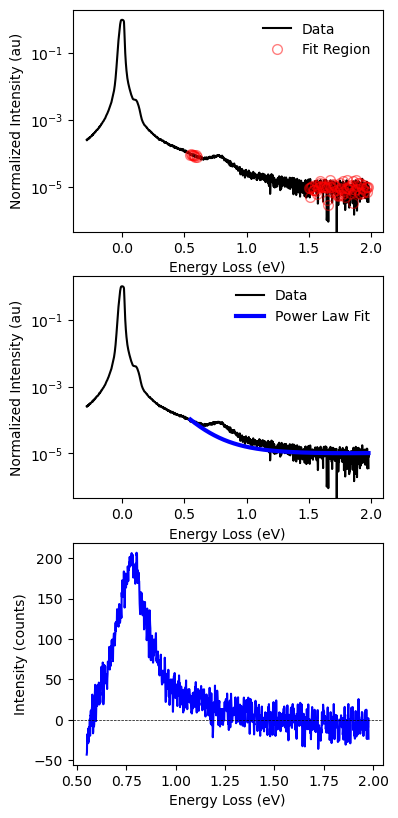

In [21]:
offset=60
E_Single_f,BG_Single_f,SI_Single_Specs0_f=FitExponential2R(E_Single,SI_Single_Specs[0]+offset,3,0.55,0.6,1.5,2.0)

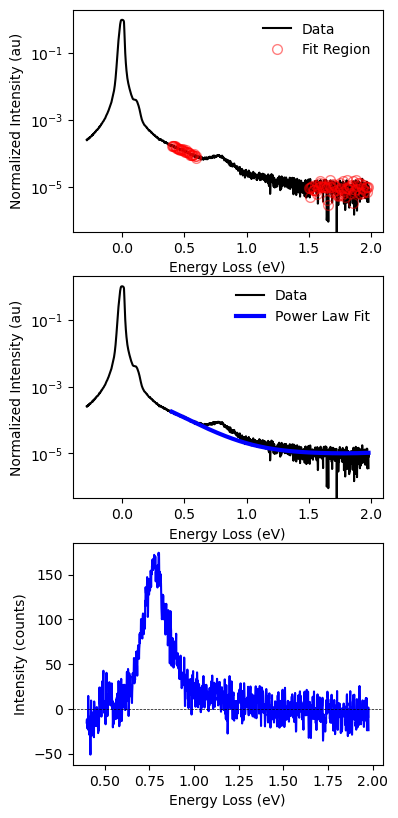

In [22]:
offset=60
E_Single_f,BG_Single_f,SI_Single_Specs0_f=FitExponential2R(E_Single,SI_Single_Specs[0]+offset,3,0.4,0.6,1.5,2.0)

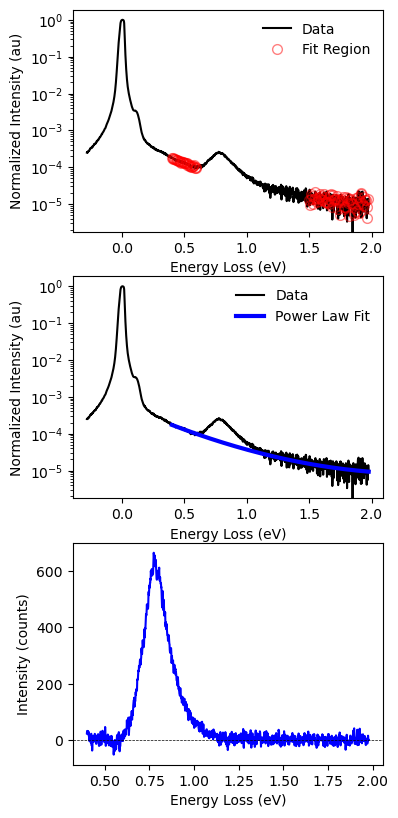

In [23]:
offset=60
E_Single_f,BG_Single_f,SI_Single_Specs1_f=FitExponential2R(E_Single,SI_Single_Specs[1]+offset,3,0.4,0.6,1.5,2.0)

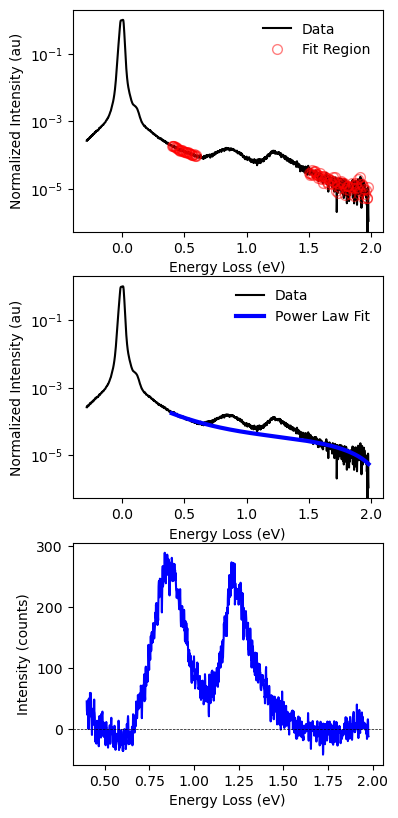

In [24]:
offset=60
E_Single_f,BG_Single_f,SI_Single_Specs2_f=FitExponential2R(E_Single,SI_Single_Specs[2]+offset,3,0.4,0.6,1.5,2.0)

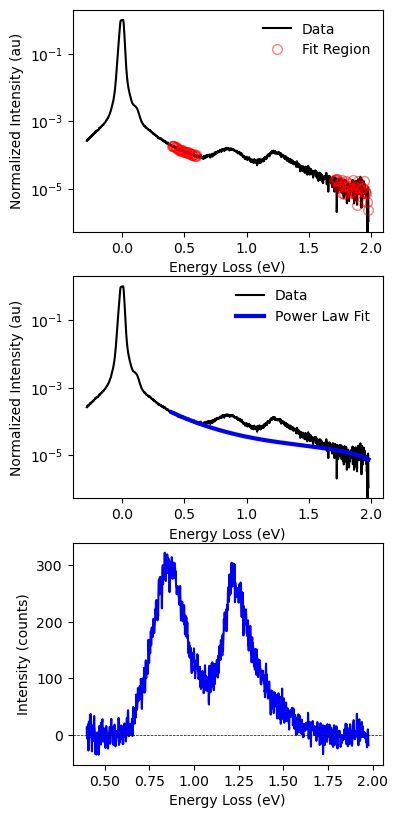

In [25]:
offset=60
E_Single_f,BG_Single_f,SI_Single_Specs2_f=FitExponential2R(E_Single,SI_Single_Specs[2]+offset,3,0.4,0.6,1.7,2.0)

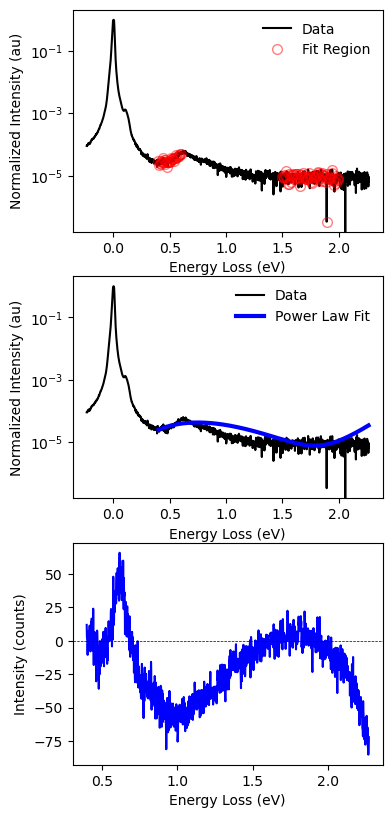

In [26]:
offset=100
E_Cluster_f,BG_Cluster_f,SI_Cluster_Specs0_f=FitExponential2R(E_Cluster,SI_Cluster_Specs[0]+offset,3,0.4,0.6,1.5,2.0)

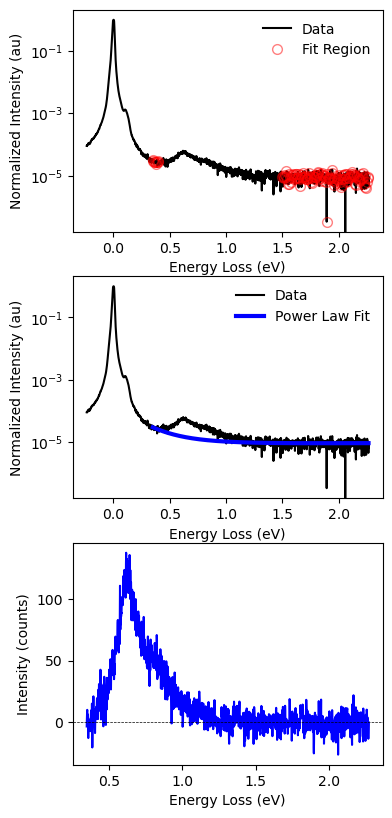

In [27]:
offset=25
E_Cluster_f,BG_Cluster_f,SI_Cluster_Specs0_f=FitExponential2R(E_Cluster,SI_Cluster_Specs[0]+offset,3,0.35,0.4,1.5,2.5)

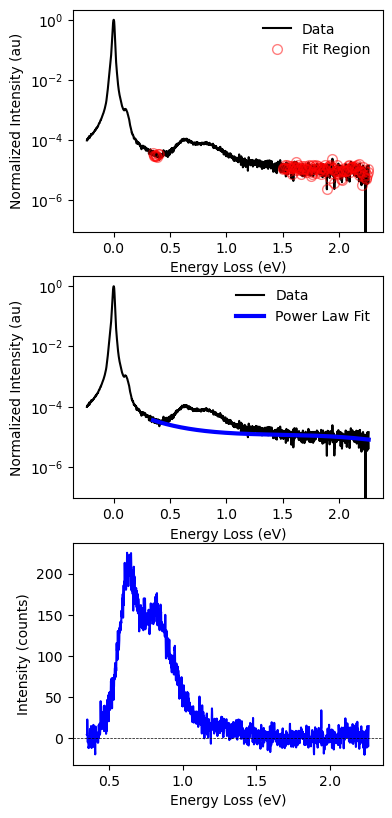

In [28]:
offset=25
E_Cluster_f,BG_Cluster_f,SI_Cluster_Specs1_f=FitExponential2R(E_Cluster,SI_Cluster_Specs[1]+offset,3,0.35,0.4,1.5,2.5)

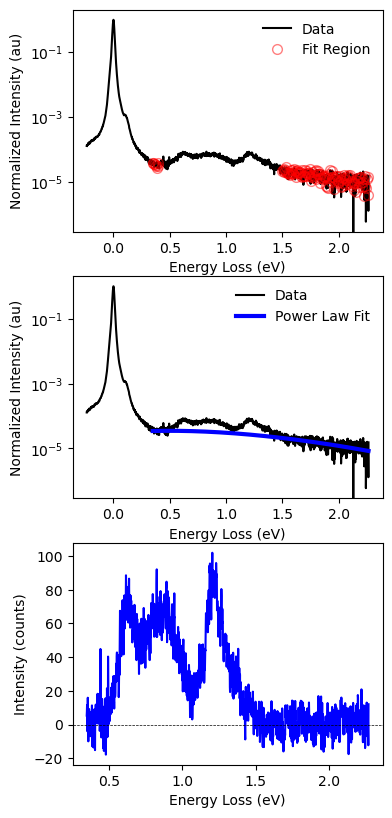

In [29]:
offset=25
E_Cluster_f,BG_Cluster_f,SI_Cluster_Specs2_f=FitExponential2R(E_Cluster,SI_Cluster_Specs[2]+offset,3,0.35,0.4,1.5,2.5)

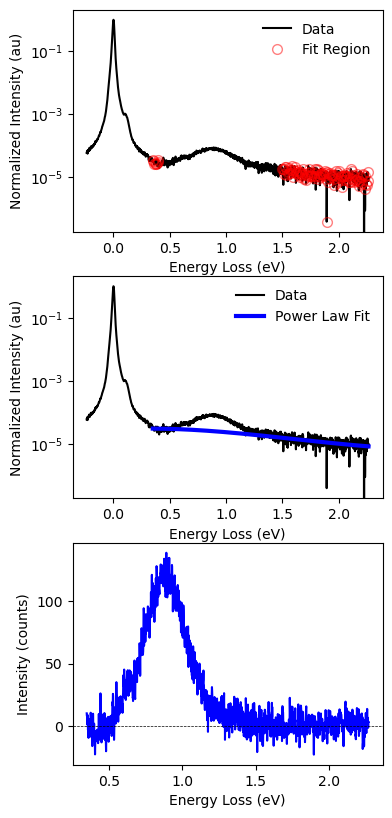

In [30]:
offset=25
E_Cluster_f,BG_Cluster_f,SI_Cluster_Specs3_f=FitExponential2R(E_Cluster,SI_Cluster_Specs[3]+offset,3,0.35,0.4,1.5,2.5)

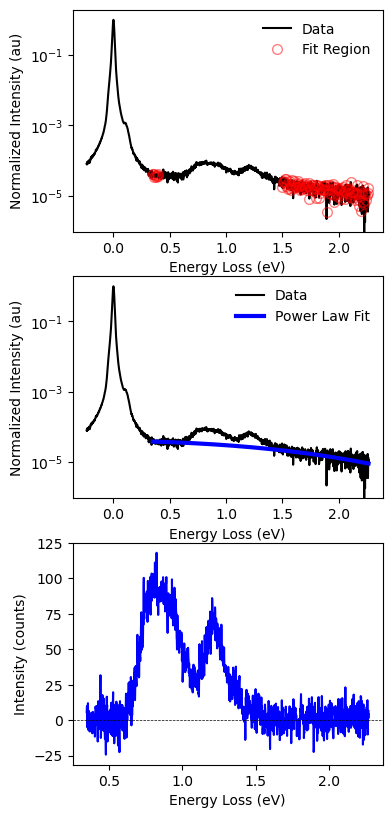

In [31]:
offset=25
E_Cluster_f,BG_Cluster_f,SI_Cluster_Specs4_f=FitExponential2R(E_Cluster,SI_Cluster_Specs[4]+offset,3,0.35,0.4,1.5,2.5)

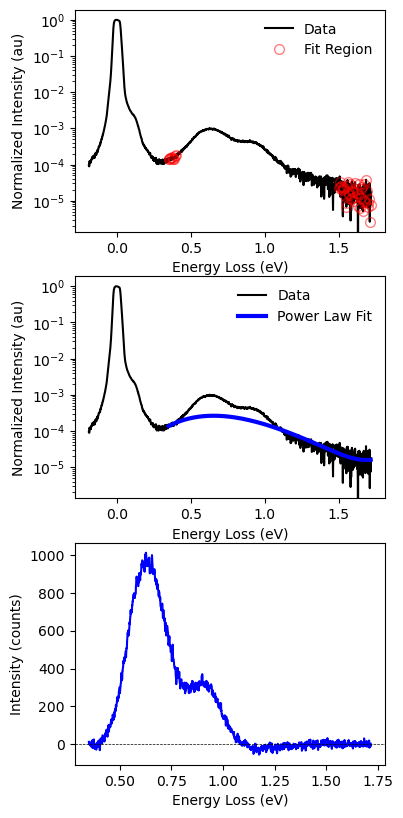

In [32]:
offset=25
E_Array_f,BG_Array_f,SI_Array_Specs0_f=FitExponential2R(E_Array,SI_Array_Specs[0]+offset,3,0.35,0.4,1.5,2.5)

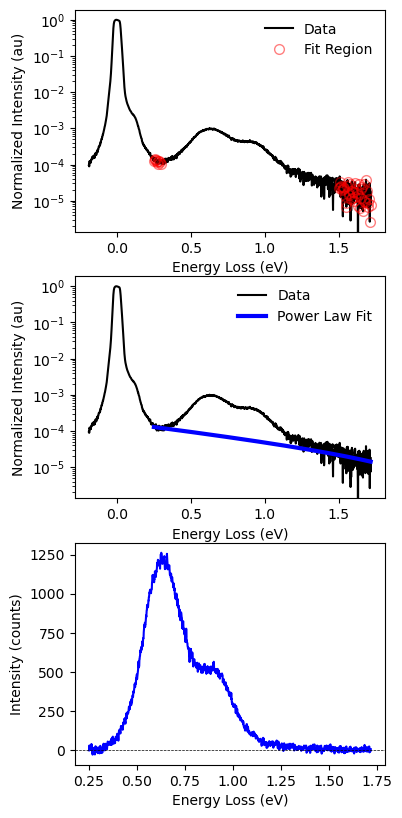

In [33]:
offset=0
E_Array_f,BG_Array_f,SI_Array_Specs0_f=FitExponential2R(E_Array,SI_Array_Specs[0]+offset,3,0.25,0.3,1.5,2.5)

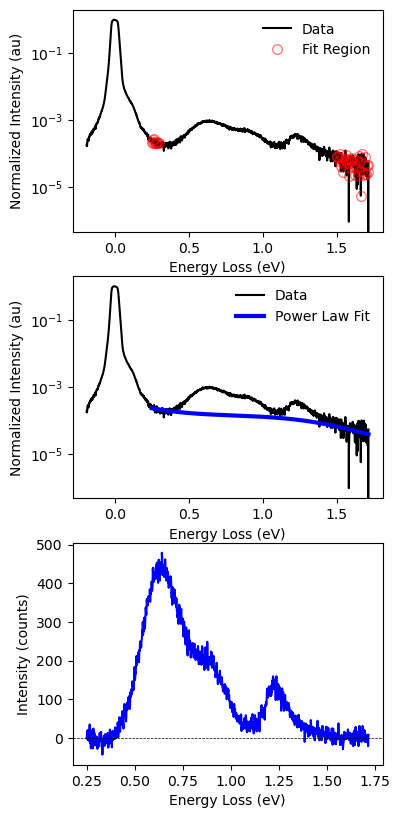

In [34]:
offset=0
E_Array_f,BG_Array_f,SI_Array_Specs1_f=FitExponential2R(E_Array,SI_Array_Specs[1]+offset,3,0.25,0.3,1.5,2.5)

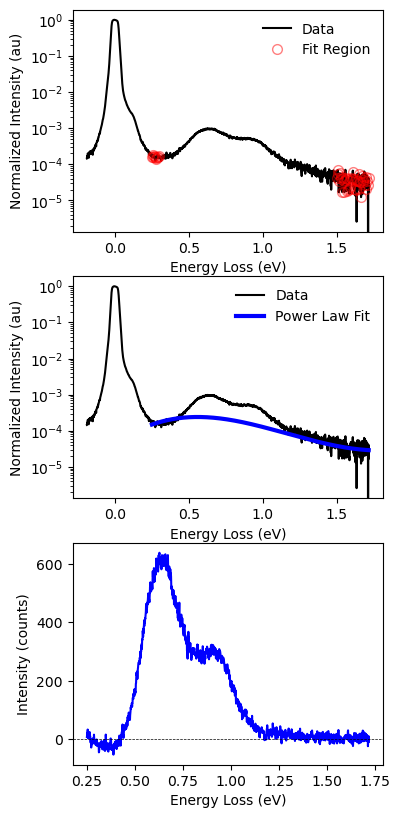

In [35]:
offset=0
E_Array_f,BG_Array_f,SI_Array_Specs2_f=FitExponential2R(E_Array,SI_Array_Specs[2]+offset,3,0.25,0.3,1.5,2.5)

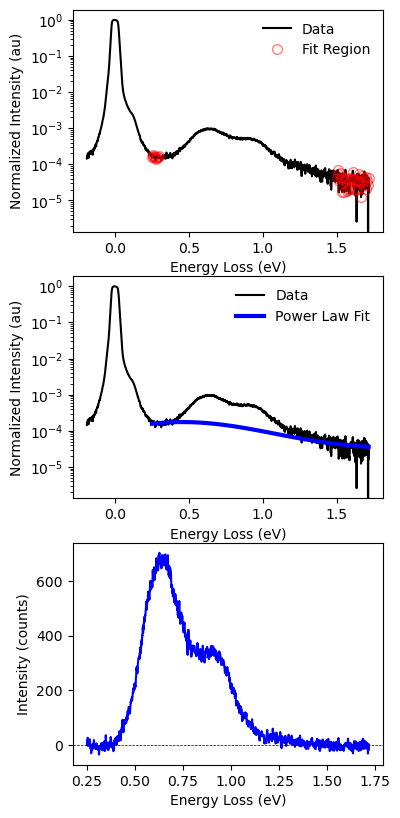

In [36]:
offset=-25
E_Array_f,BG_Array_f,SI_Array_Specs2_f=FitExponential2R(E_Array,SI_Array_Specs[2]+offset,3,0.25,0.3,1.5,2.5)

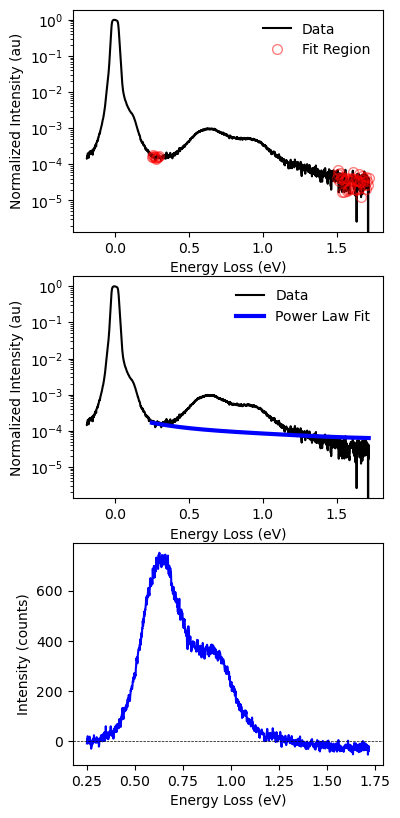

In [37]:
offset=-50
E_Array_f,BG_Array_f,SI_Array_Specs2_f=FitExponential2R(E_Array,SI_Array_Specs[2]+offset,3,0.25,0.3,1.5,2.5)

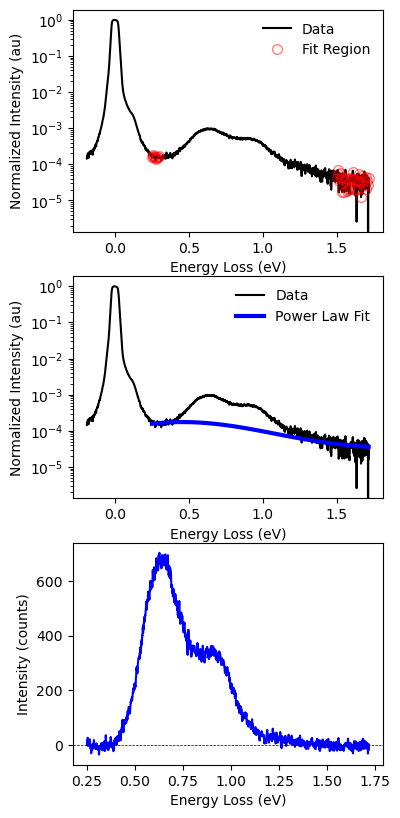

In [38]:
offset=-25
E_Array_f,BG_Array_f,SI_Array_Specs2_f=FitExponential2R(E_Array,SI_Array_Specs[2]+offset,3,0.25,0.3,1.5,2.5)

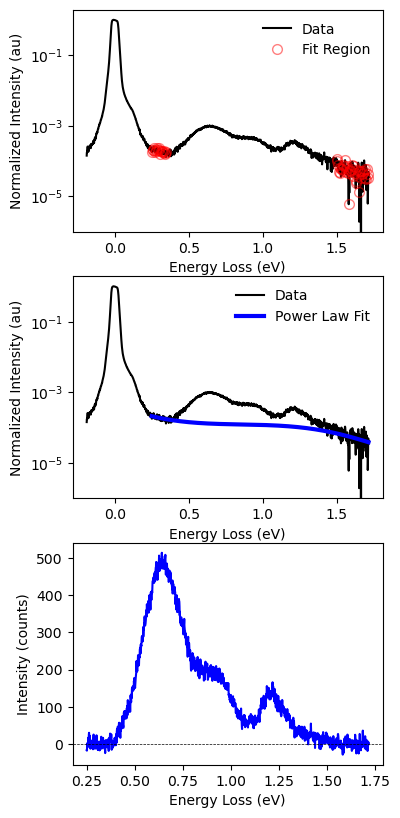

In [39]:
offset=0
E_Array_f,BG_Array_f,SI_Array_Specs3_f=FitExponential2R(E_Array,SI_Array_Specs[3]+offset,3,0.25,0.35,1.5,2.5)

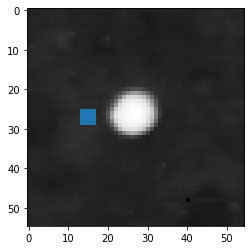

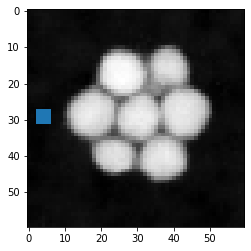

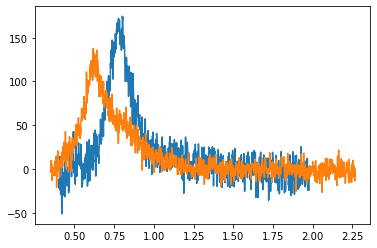

In [40]:
# Make plot of outside response (basic)

plt.imshow(Z_Single,cmap=cm.Greys_r)
plt.gca().add_patch(Rectangle(Rs_Single[0][::-1],4,4))
plt.show()

plt.imshow(Z_Cluster,cmap=cm.Greys_r)
plt.gca().add_patch(Rectangle(Rs_Cluster[0][::-1],4,4))
plt.show()

plt.plot(E_Single_f,SI_Single_Specs0_f)
plt.plot(E_Cluster_f,SI_Cluster_Specs0_f)
plt.show()

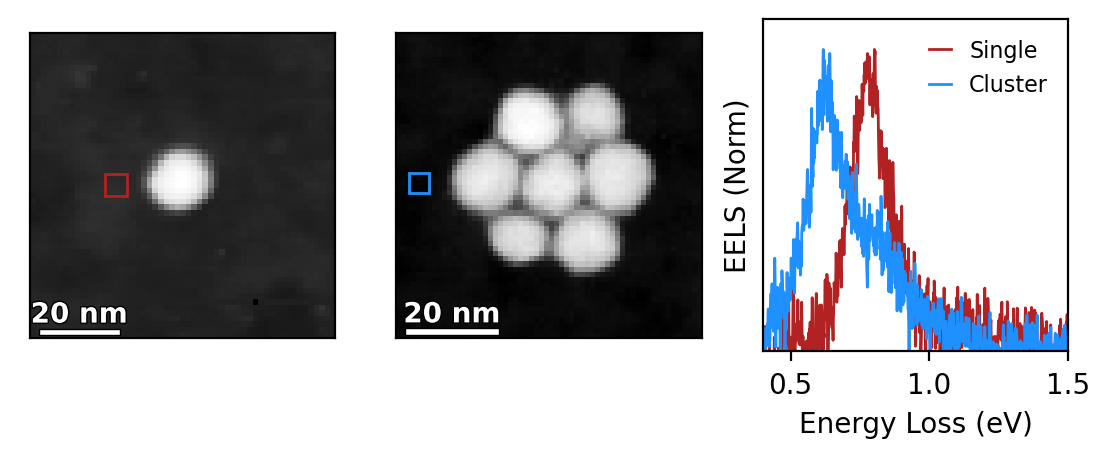

In [41]:
# Make plot of outside response (highly formatted)

Single_Color='FireBrick'
Cluster_Color='DodgerBlue'

fig=plt.figure(dpi=200,figsize=(6.7,2.2))
gs=plt.GridSpec(ncols=3,nrows=1)
ax0=fig.add_subplot(gs[0],xticks=[],yticks=[])
ax0.imshow(Z_Single,cmap=cm.Greys_r)
ax0.add_patch(Rectangle(Rs_Single[0][::-1],4,4,fc='None',ec=Single_Color))
AddScaleBar(ax0,20,Z_Single_cal)

ax1=fig.add_subplot(gs[1],xticks=[],yticks=[])
ax1.imshow(Z_Cluster,cmap=cm.Greys_r)
ax1.add_patch(Rectangle(Rs_Cluster[0][::-1],4,4,fc='None',ec=Cluster_Color))
AddScaleBar(ax1,20,Z_Cluster_cal)

ax2=fig.add_subplot(gs[2],xlim=(0.4,1.5),ylim=(0,1.1),yticks=[],xlabel='Energy Loss (eV)',ylabel='EELS (Norm)')
ax2.plot(E_Single_f,SI_Single_Specs0_f/np.amax(SI_Single_Specs0_f),color=Single_Color,lw=1,label='Single')
ax2.plot(E_Cluster_f,SI_Cluster_Specs0_f/np.amax(SI_Cluster_Specs0_f),color=Cluster_Color,lw=1,label='Cluster')
ax2.legend(frameon=False,fontsize=8,handlelength=1)


In [42]:
fig.savefig('/Users/j6h/Conferences/ImpromptuEELSAnalysis/Images/OutsideModes.png')

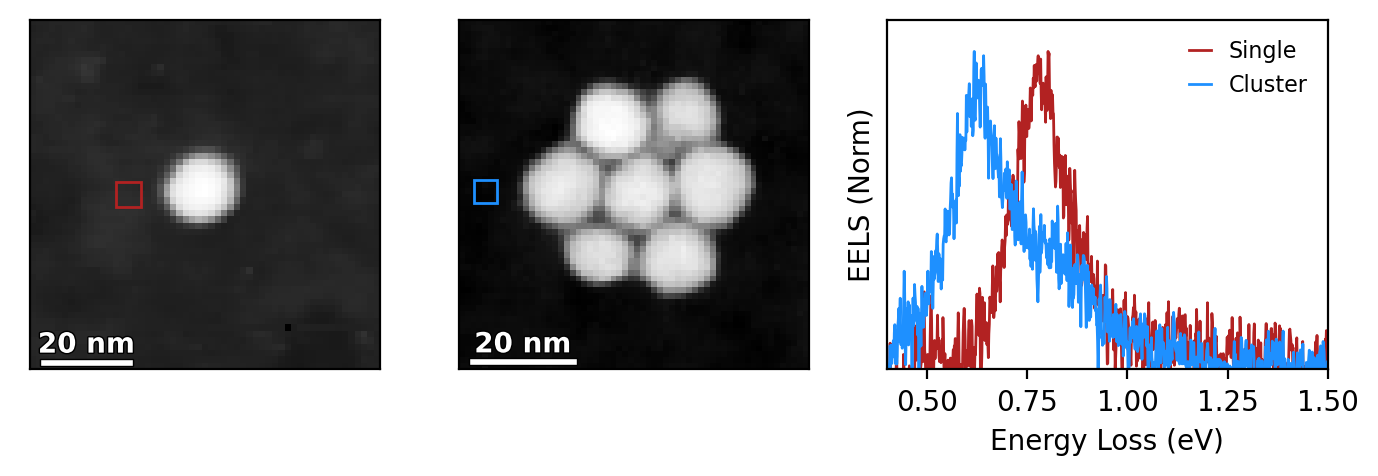

In [43]:
# Make plot of outside response (highly formatted)

Single_Color='FireBrick'
Cluster_Color='DodgerBlue'

fig=plt.figure(dpi=200,figsize=(6.7,2.2))
# ax=fig.add_axes([0,0,1,1],xticks=[],yticks=[])
gs=plt.GridSpec(ncols=3,nrows=1,width_ratios=[0.4,0.4,0.5],
                left=0.005,right=0.975,top=0.995,bottom=0.2)
ax0=fig.add_subplot(gs[0],xticks=[],yticks=[])
ax0.imshow(Z_Single,cmap=cm.Greys_r)
ax0.add_patch(Rectangle(Rs_Single[0][::-1],4,4,fc='None',ec=Single_Color))
AddScaleBar(ax0,20,Z_Single_cal)

ax1=fig.add_subplot(gs[1],xticks=[],yticks=[])
ax1.imshow(Z_Cluster,cmap=cm.Greys_r)
ax1.add_patch(Rectangle(Rs_Cluster[0][::-1],4,4,fc='None',ec=Cluster_Color))
AddScaleBar(ax1,20,Z_Cluster_cal)

ax2=fig.add_subplot(gs[2],xlim=(0.4,1.5),ylim=(0,1.1),yticks=[],xlabel='Energy Loss (eV)',ylabel='EELS (Norm)')
ax2.plot(E_Single_f,SI_Single_Specs0_f/np.amax(SI_Single_Specs0_f),color=Single_Color,lw=1,label='Single')
ax2.plot(E_Cluster_f,SI_Cluster_Specs0_f/np.amax(SI_Cluster_Specs0_f),color=Cluster_Color,lw=1,label='Cluster')
ax2.legend(frameon=False,fontsize=8,handlelength=1)

In [44]:
fig.savefig('/Users/j6h/Conferences/ImpromptuEELSAnalysis/Images/OutsideModes_better.png',dpi=600)

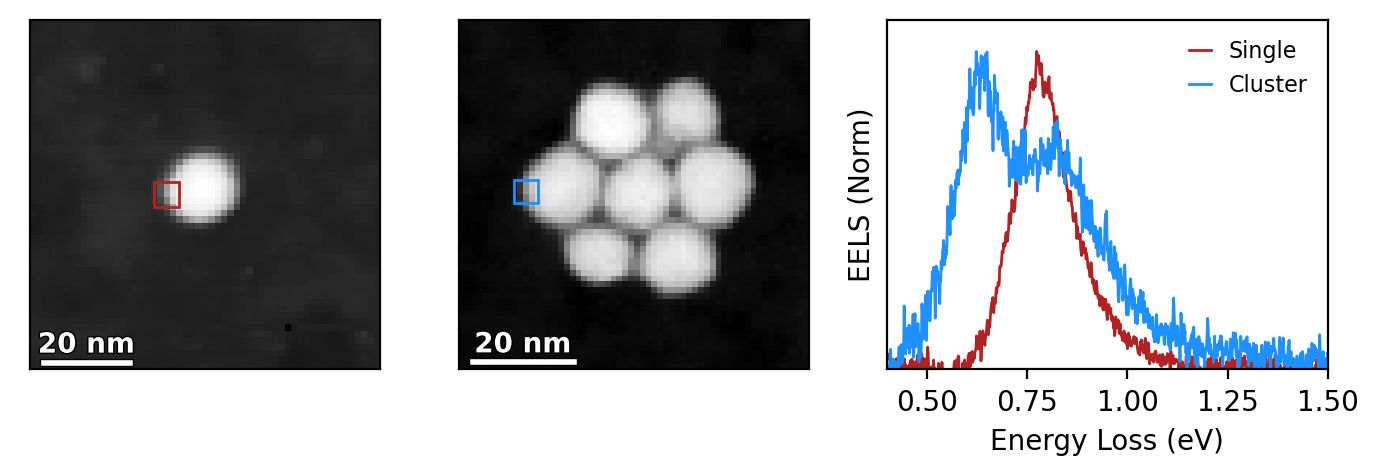

In [45]:
# Make plot of outside edge response (highly formatted)

Single_Color='FireBrick'
Cluster_Color='DodgerBlue'

fig=plt.figure(dpi=200,figsize=(6.7,2.2))
# ax=fig.add_axes([0,0,1,1],xticks=[],yticks=[])
gs=plt.GridSpec(ncols=3,nrows=1,width_ratios=[0.4,0.4,0.5],
                left=0.005,right=0.975,top=0.995,bottom=0.2)
ax0=fig.add_subplot(gs[0],xticks=[],yticks=[])
ax0.imshow(Z_Single,cmap=cm.Greys_r)
ax0.add_patch(Rectangle(Rs_Single[1][::-1],4,4,fc='None',ec=Single_Color))
AddScaleBar(ax0,20,Z_Single_cal)

ax1=fig.add_subplot(gs[1],xticks=[],yticks=[])
ax1.imshow(Z_Cluster,cmap=cm.Greys_r)
ax1.add_patch(Rectangle(Rs_Cluster[1][::-1],4,4,fc='None',ec=Cluster_Color))
AddScaleBar(ax1,20,Z_Cluster_cal)

ax2=fig.add_subplot(gs[2],xlim=(0.4,1.5),ylim=(0,1.1),yticks=[],xlabel='Energy Loss (eV)',ylabel='EELS (Norm)')
ax2.plot(E_Single_f,SI_Single_Specs1_f/np.amax(SI_Single_Specs1_f),color=Single_Color,lw=1,label='Single')
ax2.plot(E_Cluster_f,SI_Cluster_Specs1_f/np.amax(SI_Cluster_Specs1_f),color=Cluster_Color,lw=1,label='Cluster')
ax2.legend(frameon=False,fontsize=8,handlelength=1)

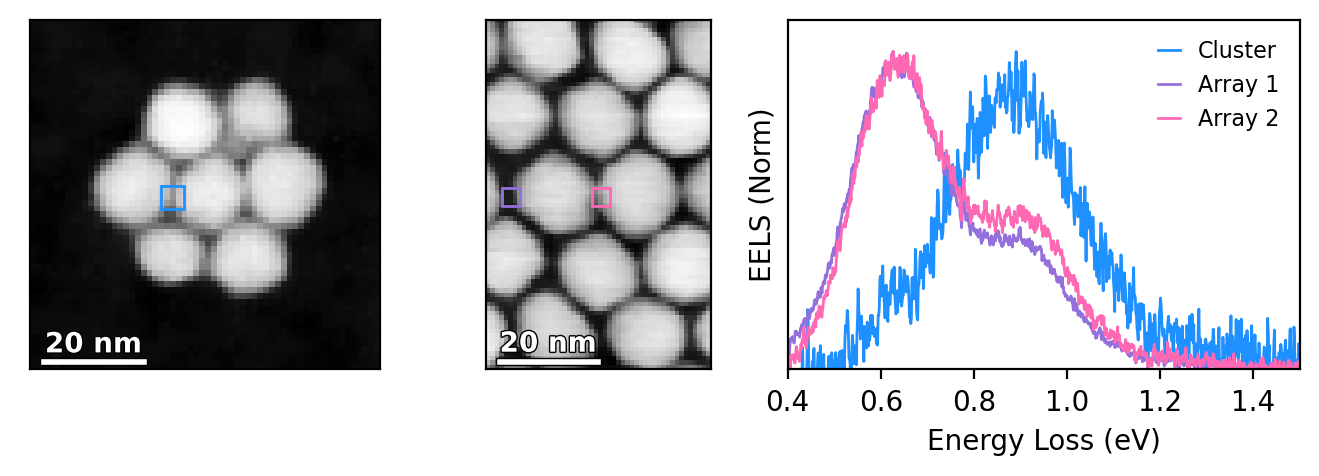

In [46]:
# Make plot of inside edge response (highly formatted)

Cluster_Color='DodgerBlue'
Array_Color1='MediumPurple'
Array_Color2='HotPink'

fig=plt.figure(dpi=200,figsize=(6.7,2.2))
# ax=fig.add_axes([0,0,1,1],xticks=[],yticks=[])
gs=plt.GridSpec(ncols=3,nrows=1,width_ratios=[0.4,0.22,0.5],
                left=0.005,right=0.975,top=0.995,bottom=0.2)

ax0=fig.add_subplot(gs[0],xticks=[],yticks=[])
ax0.imshow(Z_Cluster,cmap=cm.Greys_r)
ax0.add_patch(Rectangle(Rs_Cluster[3][::-1],4,4,fc='None',ec=Cluster_Color))
AddScaleBar(ax0,20,Z_Cluster_cal)

ax1=fig.add_subplot(gs[1],xticks=[],yticks=[])
ax1.imshow(Z_Array,cmap=cm.Greys_r)
ax1.add_patch(Rectangle(Rs_Array[0][::-1],4,4,fc='None',ec=Array_Color1))
ax1.add_patch(Rectangle(Rs_Array[2][::-1],4,4,fc='None',ec=Array_Color2))
AddScaleBar(ax1,20,Z_Array_cal)

ax2=fig.add_subplot(gs[2],xlim=(0.4,1.5),ylim=(0,1.1),yticks=[],xlabel='Energy Loss (eV)',ylabel='EELS (Norm)')
ax2.plot(E_Cluster_f,SI_Cluster_Specs3_f/np.amax(SI_Cluster_Specs3_f),color=Cluster_Color,lw=1,label='Cluster')
ax2.plot(E_Array_f,SI_Array_Specs0_f/np.amax(SI_Array_Specs0_f),color=Array_Color1,lw=1,label='Array 1')
ax2.plot(E_Array_f,SI_Array_Specs2_f/np.amax(SI_Array_Specs2_f),color=Array_Color2,lw=1,label='Array 2')
ax2.legend(frameon=False,fontsize=8,handlelength=1)

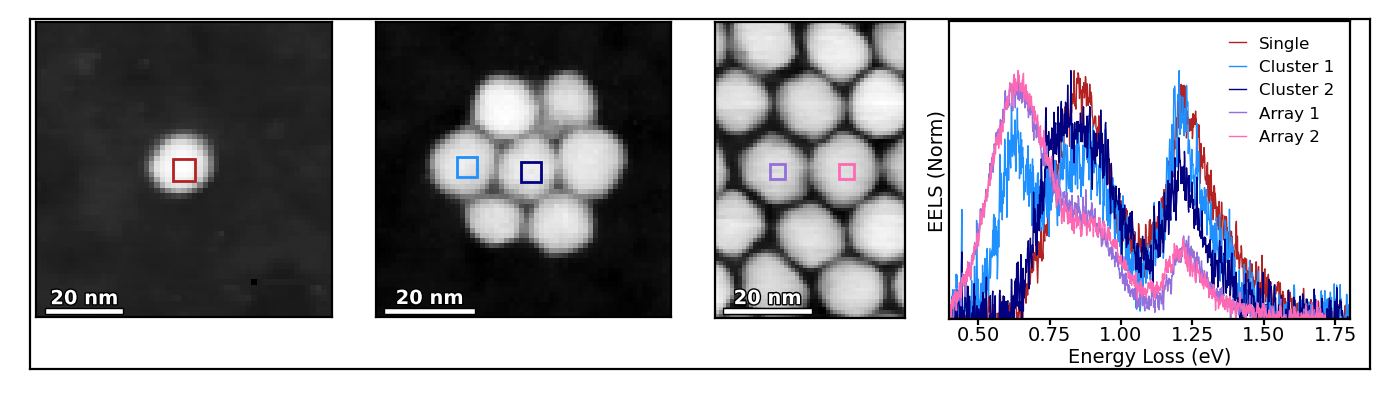

In [47]:
# Make plot of particle body response (highly formatted)

Single_Color='FireBrick'
Cluster_Color1='DodgerBlue'
Cluster_Color2='Navy'
Array_Color1='MediumPurple'
Array_Color2='HotPink'

fig=plt.figure(dpi=200,figsize=(6.7,1.75))
ax=fig.add_axes([0,0,1,1],xticks=[],yticks=[])
gs=plt.GridSpec(ncols=4,nrows=1,width_ratios=[0.295,0.295,0.19,0.4],
                left=0.005,right=0.985,top=0.995,bottom=0.145,wspace=0.15)
ax0=fig.add_subplot(gs[0],xticks=[],yticks=[])
ax0.imshow(Z_Single,cmap=cm.Greys_r)
ax0.add_patch(Rectangle(Rs_Single[2][::-1],4,4,fc='None',ec=Single_Color))
AddScaleBar(ax0,20,Z_Single_cal,fontsize=7)

ax1=fig.add_subplot(gs[1],xticks=[],yticks=[])
ax1.imshow(Z_Cluster,cmap=cm.Greys_r)
ax1.add_patch(Rectangle(Rs_Cluster[2][::-1],4,4,fc='None',ec=Cluster_Color1))
ax1.add_patch(Rectangle(Rs_Cluster[4][::-1],4,4,fc='None',ec=Cluster_Color2))
AddScaleBar(ax1,20,Z_Cluster_cal,fontsize=7)

ax2=fig.add_subplot(gs[2],xticks=[],yticks=[])
ax2.imshow(Z_Array,cmap=cm.Greys_r)
ax2.add_patch(Rectangle(Rs_Array[1][::-1],4,4,fc='None',ec=Array_Color1))
ax2.add_patch(Rectangle(Rs_Array[3][::-1],4,4,fc='None',ec=Array_Color2))
AddScaleBar(ax2,20,Z_Array_cal,fontsize=7)

ax3=fig.add_subplot(gs[3],xlim=(0.4,1.8),ylim=(0,1.2),yticks=[])
ax3.plot(E_Single_f,SI_Single_Specs2_f/np.amax(SI_Single_Specs2_f),color=Single_Color,lw=0.5,label='Single')
ax3.plot(E_Cluster_f,SI_Cluster_Specs2_f/np.amax(SI_Cluster_Specs2_f),color=Cluster_Color1,lw=0.5,label='Cluster 1')
ax3.plot(E_Cluster_f,SI_Cluster_Specs4_f/np.amax(SI_Cluster_Specs4_f),color=Cluster_Color2,lw=0.5,label='Cluster 2')
ax3.plot(E_Array_f,SI_Array_Specs1_f/np.amax(SI_Array_Specs1_f),color=Array_Color1,lw=0.5,label='Array 1')
ax3.plot(E_Array_f,SI_Array_Specs3_f/np.amax(SI_Array_Specs3_f),color=Array_Color2,lw=0.5,label='Array 2')
ax3.legend(frameon=False,fontsize=6,handlelength=1)
ax3.set_xlabel('Energy Loss (eV)',fontsize=7,labelpad=1)
ax3.set_ylabel('EELS (Norm)',fontsize=7,labelpad=1)
ax3.tick_params(labelsize=7,length=2,pad=0.5)